## Carregando e limpando o dataset para uso

In [105]:
import pandas as pd 
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as KL
import tensorflow.keras.models as KM
import matplotlib.pyplot as plt
import matplotlib
from os.path import join

# Extraídos da documentação do dataset
LABELS = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Carregar o dataset
df_train = pd.read_csv(join("data", "fashion-mnist_train.csv"))
df_test = pd.read_csv(join("data", "fashion-mnist_test.csv"))\

df_train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
# Checando se há valores NA 
ser = df_train.isnull().sum()
print(ser.loc[ser > 0])

ser = df_test.isnull().sum()
print(ser.loc[ser > 0]) # Tudo limpo

Series([], dtype: int64)
Series([], dtype: int64)


In [107]:
# Retirando os labels de cada imagem e apagando do dataframe principal 
y_train = df_train[['label']].to_numpy()
y_test = df_test[['label']].to_numpy()

df_train.drop(columns=['label'], inplace=True)
df_test.drop(columns=['label'], inplace=True)

y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)
y_train

array([2, 9, 6, ..., 8, 8, 7], dtype=int64)

Essa peça é 'Pullover'


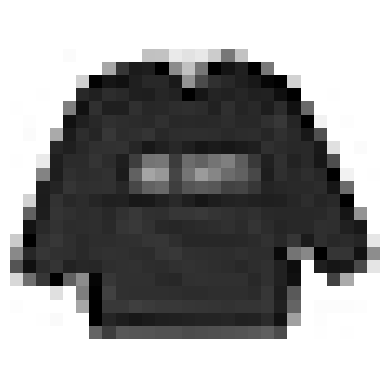

In [108]:
# Mostrando uma imagem e seu label 
piece = df_train.iloc[0, :].to_numpy()
piece_image = piece.reshape(28, 28)
plt.imshow(piece_image, cmap=matplotlib.cm.binary)
plt.axis("off")
print("Essa peça é '", LABELS[y_train[0]], "'", sep="")
plt.show()


In [109]:
# Normalizando os valores dos pixels
x_train = df_train.to_numpy() / 255
x_test = df_test.to_numpy() / 255

x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

x_train.shape

(60000, 28, 28, 1)

## Criando o modelo e experimentando com os parâmetros 

In [110]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [111]:
# Função auxiliar para criar modelos para acomodar todos os parâmetros que vamos testar
def bootstrap_model(n=1, filt=None, dense=16, batch=False, drop=0):
    # Validação dos filtros
    if not filt:
        filt = [16 for _ in range(n)] 
    if len(filt) != n:
        raise ValueError("Numero de camadas e numero de filtros estão diferentes!")

    # Invocação de um novo modelo
    model = Sequential()

    # Cria a camada de input com uma convolução-pooling
    model.add(Conv2D(filters=filt[0], kernel_size=(3,3), strides=1, activation="relu", padding="same", input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Cria camadas de convolução-pooling adicionais 
    for i in range(n - 1):
        model.add(Conv2D(filters=filt[i + 1], kernel_size=(3,3), strides=1, padding="same", activation="relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    # Cria uma camada densa 
    model.add(Flatten())
    model.add(Dense(dense, activation="relu"))
    # Coloca batch e drop conforme os parâmetros
    if batch:
        model.add(BatchNormalization())
    if drop != 0:
        model.add(Dropout(drop))

    # Cria camada de output
    model.add(Dense(10, activation="softmax"))
    # Coloca batch e drop conforme os parâmetros
    if batch:
        model.add(BatchNormalization())
    if drop != 0:
        model.add(Dropout(drop))

    return model

In [113]:
# Testando o número de camadas
best, best_model, best_n = 0, None, 0
for n in (1, 2, 3, 4):
    # Limpando o cache do keras
    tf.keras.backend.clear_session()

    # Criando um modelo com o número de camadas e compilando
    cnn = bootstrap_model(n)
    cnn.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Treinando 
    print(f"Treinando com {n} camadas de convolução-pooling")
    cnn.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_test, y_test), verbose=0)
    
    # Checando a acurácia
    test_loss, test_acc = cnn.evaluate(x_test, y_test, verbose=0)
    print(f"Acurácia de {(test_acc * 100):.2f}%\n")

    # Acha o melhor valor pra esse parâmetro
    if test_acc > best:
        best = test_acc
        best_n = n



Treinando com 1 camadas de convolução-pooling
Acurácia de 89.25%

Treinando com 2 camadas de convolução-pooling
Acurácia de 87.17%

Treinando com 3 camadas de convolução-pooling
Acurácia de 86.88%

Treinando com 4 camadas de convolução-pooling
Acurácia de 87.16%



In [114]:
from itertools import combinations_with_replacement

# Retorna todas as combinações de filters com o numéro de camadas que temos
combinations = list(combinations_with_replacement((16, 32, 64), best_n))

# Testando o número de filters
best, best_filter = 0, 0
for f in combinations:
    tf.keras.backend.clear_session()

    # Cria um modelo com os parâmetros ótimos até o momento e compila
    cnn = bootstrap_model(n=best_n, filt=f)
    cnn.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Treinando 
    print(f"Treinando a combinação de filtros: {f}")
    cnn.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_test, y_test), verbose=0)
    
    # Checando a acurácia
    test_loss, test_acc = cnn.evaluate(x_test, y_test, verbose=0)
    print(f"Acurácia de {(test_acc * 100):.2f}%\n")

    # Acha o melhor valor pra esse parâmetro
    if test_acc > best:
        best = test_acc
        best_n = n

Treinando a combinação de filtros: (16,)
Acurácia de 88.87%

Treinando a combinação de filtros: (32,)
Acurácia de 89.03%

Treinando a combinação de filtros: (64,)
Acurácia de 90.78%



In [115]:
best, best_dense = 0, 0 
for d in (16, 32, 64, 128):
    tf.keras.backend.clear_session()

    # Cria um modelo com os parâmetros ótimos até o momento e compila
    cnn = bootstrap_model(n=best_n, filt=best_filter, dense=d)
    cnn.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Treinando
    print(f"Treinando com a camada densa de tamanho {d}")
    cnn.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_test, y_test), verbose=0)
    
    # Checando a acurácia
    test_loss, test_acc = cnn.evaluate(x_test, y_test, verbose=0)
    print(f"Acurácia de {(test_acc * 100):.2f}%\n")

    # Acha o melhor valor pra esse parâmetro
    if test_acc > best:
        best = test_acc
        best_n = n

Treinando com a camada densa de tamanho 16
Acurácia de 90.50%

Treinando com a camada densa de tamanho 32
Acurácia de 90.64%

Treinando com a camada densa de tamanho 64
Acurácia de 91.81%

Treinando com a camada densa de tamanho 128
Acurácia de 91.84%



In [116]:
best, best_drop = 0, 0 
for dr in (0, .2, .4, .6, .8):
    tf.keras.backend.clear_session()

    # Cria um modelo com os parâmetros ótimos até o momento e compila
    cnn = bootstrap_model(n=best_n, filt=best_filter, dense=best_dense, drop=dr)
    cnn.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Treinando
    print(f"Treinando com o drop de {dr}")
    cnn.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_test, y_test), verbose=0)
    
    # Checando a acurácia
    test_loss, test_acc = cnn.evaluate(x_test, y_test, verbose=0)
    print(f"Acurácia de {(test_acc * 100):.2f}%\n")

    # Acha o melhor valor pra esse parâmetro
    if test_acc > best:
        best = test_acc
        best_n = n

Treinando com o drop de 0
Acurácia de 91.83%

Treinando com o drop de 0.2
Acurácia de 89.55%

Treinando com o drop de 0.4
Acurácia de 88.77%

Treinando com o drop de 0.6
Acurácia de 63.82%

Treinando com o drop de 0.8
Acurácia de 14.01%



## Fazendo Data Augmentation

In [117]:
# Trâmites para criação de uma base com Data Augmentation
import random
from PIL import Image
from matplotlib import cm

# Efeitos de transformação de imagem
EFFECTS = [
    Image.TRANSVERSE,
    Image.TRANSPOSE,
    Image.FLIP_LEFT_RIGHT,
    Image.FLIP_TOP_BOTTOM,
    Image.ROTATE_90,
    Image.ROTATE_180,
    Image.ROTATE_270,
]

LEN_EFFECTS = len(EFFECTS) - 1

def data_augmentation(x, y, cols):
    for i, item in enumerate(x):
        if not i % 10 == 0:
            continue 
        
        print(i)
        aux = np.squeeze(item, axis=2) 
        img = Image.fromarray((aux * 255).astype(np.uint8))

        # Aplica uma rotação aleatória na imagem
        flip_img = img.transpose(EFFECTS[random.randint(0, LEN_EFFECTS)])

        # Retorna imagem como um array e coloca no formato que estamos usando
        pic = (np.array(flip_img) / 255).reshape(-1, 28, 28, 1)

        # Adiciona ao array de imagens
        x = np.append(x, pic, axis=0)
        y = np.append(y, y[i].reshape(1), axis=0)

    # Faz algumas transformações para salvar como CSV
    new_x = x.reshape(x.shape[0], 784)
    new_y = y.reshape(y.shape[0], 1)
    new_x = (new_x * 255).astype(np.uint8)
    new_y = new_y.astype(np.uint8)
    df_data = np.concatenate((new_y, new_x), axis=1)

    # Cria um novo dataframe adicionando as imagens transformadas
    df_new = pd.DataFrame(df_data, columns=cols)

    # Salva como CSV
    df_new.to_csv(join("data", "fashion-mnist_train_augmented.csv"), index=False)

### Base de Data Augmentation

In [118]:

# ========= Se não tiver a base com data augmentation, rodar isso: ========= 

# cols = list(df_train.columns)
# cols.insert(0, 'label')
# data_augmentation(x_train, y_train, cols)


# ========= Se já tiver, isso aqui: ========= 
df_aug = pd.read_csv(join("data", "fashion-mnist_train_augmented.csv"))

# Retirando os labels de cada imagem e apagando do dataframe principal 
y_aug = df_aug[['label']].to_numpy()
df_aug.drop(columns=['label'], inplace=True)
y_aug = np.squeeze(y_aug)

# Normalizando os valores dos pixels
x_aug = df_aug.to_numpy() / 255
x_aug = np.reshape(x_aug, (-1, 28, 28, 1))
x_aug.shape


(66000, 28, 28, 1)

Essa peça é 'T-shirt/top'


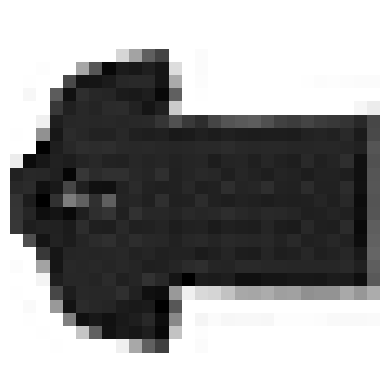

In [119]:
# Mostrando uma imagem modificada e seu label 
plt.imshow(x_aug[-1], cmap=matplotlib.cm.binary)
plt.axis("off")
print("Essa peça é '", LABELS[y_aug[-1]], "'", sep="")
plt.show()

In [120]:
# Descobrindo se o batch é melhor ativado ou desativado, e usando a base de data augmentation
best, best_batch = 0, None
for b in (True, False):
    # Aplicando Data Augmentation
    tf.keras.backend.clear_session()

    # Cria um modelo com os parâmetros ótimos até o momento e compila
    cnn = bootstrap_model(n=best_n, filt=best_filter, dense=best_dense, drop=best_drop, batch=b)
    cnn.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    print(f"Treinando usando base de imagens data augmentation com BatchOptimization={b}")
    cnn.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_test, y_test), verbose=0)
    
    # Checando a acurácia
    test_loss, test_acc = cnn.evaluate(x_test, y_test, verbose=0)
    print(f"Acurácia de {(test_acc * 100):.2f}%\n")

    # Acha o melhor valor pra esse parâmetro
    if test_acc > best:
        best = test_acc
        best_n = n

Treinando usando base de imagens data augmentation com BatchOptimization=True
Acurácia de 67.83%

Treinando usando base de imagens data augmentation com BatchOptimization=False
Acurácia de 91.47%



## Validação de 5-fold 

In [124]:
from sklearn.model_selection import KFold

# Fazendo validação de de 5-fold com acurácia.
for kfold, (train, test) in enumerate(KFold(n_splits=5, shuffle=True).split(x_aug, y_aug)):
    tf.keras.backend.clear_session()

    # Criando o modelo com os parametros otimizados
    cnn_model = bootstrap_model(n=best_n, filt=best_filter, dense=best_dense, drop=best_drop, batch=best_batch)
    cnn_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Treinando com o k-fold
    print(f"Treinando o fold {kfold + 1}")
    cnn_model.fit(x_aug[train], y_aug[train], batch_size=128, epochs=5, validation_data=(x_aug[test], y_aug[test]), verbose=0)

    # Avaliando o modelo com acurácia
    test_loss, test_acc = cnn_model.evaluate(x_test, y_test)
    print(f"Perda do Teste: {test_loss}\nAcurácia do Teste: {test_acc}\n")

Treinando o fold 1
313/313 [==============================] - 2s 8ms/step - loss: 0.2476 - accuracy: 0.9093
Perda do Teste: 0.24755534529685974
Acurácia do Teste: 0.9093000292778015

Treinando o fold 2
313/313 [==============================] - 2s 7ms/step - loss: 0.2442 - accuracy: 0.9148
Perda do Teste: 0.24424758553504944
Acurácia do Teste: 0.9147999882698059

Treinando o fold 3
313/313 [==============================] - 2s 7ms/step - loss: 0.2464 - accuracy: 0.9119
Perda do Teste: 0.24643521010875702
Acurácia do Teste: 0.911899983882904

Treinando o fold 4
313/313 [==============================] - 3s 8ms/step - loss: 0.2338 - accuracy: 0.9176
Perda do Teste: 0.23382334411144257
Acurácia do Teste: 0.9175999760627747

Treinando o fold 5
313/313 [==============================] - 2s 6ms/step - loss: 0.2356 - accuracy: 0.9140
Perda do Teste: 0.2356077879667282
Acurácia do Teste: 0.9139999747276306

